In [ ]:
import kagglehub
rmisra_news_category_dataset_path = kagglehub.dataset_download('rmisra/news-category-dataset')

print('Data source import complete.')


# NEWS CLASSIFICATION TASK

I am Rishabh Jain and i wanted to compare the results of a news classification task using a rnn, lstm and a transformer

### STEP 1: Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import string
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import nltk
import re
import os
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
os.environ["TOKENIZERS_PARALLELISM"] = "false"

2025-07-02 17:24:38.180367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751477078.572538      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751477078.674644      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# STEP 2: Getting the dataset

In [ ]:
df = pd.read_json("/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json", lines = True)
df = df[['headline', 'category']]
df = df[df['category'].map(df['category'].value_counts()) > 1000]


### STEP 3: Preprocessing the data and train test split

- tokenizing the data
- making the vocabulary
- encoding the data
- splitting the data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

def tokenizing_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    return tokens

df['tokens'] = df['headline'].apply(tokenizing_text)

all_words = [word for tokens in df['tokens'] for word in tokens]
vocab_counter= Counter(all_words)
most_common = vocab_counter.most_common(15000)
vocab = {word: i+2 for i,(word,_) in enumerate(most_common)}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1
vocab_size = len(vocab)

def encode_sentence(tokens, vocab, max_len=20):
    tokens = tokens[:max_len]
    ids = [vocab.get(w, vocab['<UNK>']) for w in tokens]
    ids += [vocab['<PAD>']] * (max_len - len(ids))
    return ids

df['input_ids'] = df['tokens'].apply(lambda x: encode_sentence(x, vocab))

le = LabelEncoder()
df['label'] = le.fit_transform(df['category'])
num_classes = len(le.classes_)

indices = list(df.index)
idx = list(df['input_ids'])
labelx = list(df['label'])
idx_train, idx_test, labelx_train, labelx_test, id_train, id_test = train_test_split(idx, labelx, indices, test_size=0.2, random_state=63)

# Transformer section
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
hf_df = df[['headline', 'label']]
hf_train, hf_test = train_test_split(hf_df, test_size=0.2, random_state=63)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### STEP 4: Prepping  and loading the dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
class Data(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

class HF_Data(Dataset):
    def __init__(self, dataframe):
        self.encodings = tokenizer(list(dataframe['headline']), padding=True, truncation=True, return_tensors="pt")
        self.labels = torch.tensor(list(dataframe['label']))

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HF_Data(hf_train)
test_dataset = HF_Data(hf_test)

train_data = Data(idx_train, labelx_train)
test_data = Data(idx_test, labelx_test)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True,num_workers=4)
test_loader = DataLoader(test_data, batch_size=128,num_workers=4)


### STEP 5: Architecture of the model

In [ ]:
class RNNx(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim,dropout=0.3, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

class LSTMx(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim,dropout=0.3, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out


### STEP 6: Model training code

In [ ]:
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_model = RNNx(vocab_size=len(vocab),embed_dim=100,hidden_dim=128,num_classes=num_classes,num_layers=1)
lstm_model = LSTMx(vocab_size=len(vocab),embed_dim=100,hidden_dim=128,num_classes=num_classes,num_layers=1)
transformer_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)

def train(model, train_loader, num_epochs):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    lossfn = nn.CrossEntropyLoss()
    train_losses = []
    train_accs = []

    for epoch in range(num_epochs):
        model.train()
        trainloss = 0.0
        traincorrect = 0
        train_size = len(train_loader.dataset)

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = lossfn(outputs, labels)
            loss.backward()
            optimizer.step()
            trainloss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            traincorrect += (predicted == labels).sum().item()

        avgtrainloss = trainloss / len(train_loader.dataset)
        trainacc = traincorrect / len(train_loader.dataset)
        train_losses.append(avgtrainloss)
        train_accs.append(trainacc)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avgtrainloss:.4f} , Train Acc: {trainacc:.4f}")

    return train_losses, train_accs

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    eval_strategy="steps",
    logging_strategy="steps",
    logging_steps = 500,
    eval_steps=500,
    save_strategy="no",
    load_best_model_at_end=False,
    logging_dir="./logs",
    report_to="none",
    fp16=True,
)

trainer = Trainer(
    model=transformer_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {
        "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))
    }
)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/1828355823.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### STEP 7: Training the models

In [ ]:
train_losses_rnn, train_accs_rnn = train(rnn_model,train_loader,num_epochs=15)
train_losses_lstm, train_accs_lstm = train(lstm_model,train_loader,num_epochs=15)
trainer.train()

Epoch 1/15 - Train Loss: 3.2166 , Train Acc: 0.1929
Epoch 2/15 - Train Loss: 2.8377 , Train Acc: 0.2736
Epoch 3/15 - Train Loss: 2.6833 , Train Acc: 0.3044
Epoch 4/15 - Train Loss: 2.5637 , Train Acc: 0.3281
Epoch 5/15 - Train Loss: 2.4617 , Train Acc: 0.3533
Epoch 6/15 - Train Loss: 2.3613 , Train Acc: 0.3816
Epoch 7/15 - Train Loss: 2.2786 , Train Acc: 0.4038
Epoch 8/15 - Train Loss: 2.2063 , Train Acc: 0.4222
Epoch 9/15 - Train Loss: 2.1415 , Train Acc: 0.4410
Epoch 10/15 - Train Loss: 2.0838 , Train Acc: 0.4556
Epoch 11/15 - Train Loss: 2.0250 , Train Acc: 0.4707
Epoch 12/15 - Train Loss: 1.9812 , Train Acc: 0.4807
Epoch 13/15 - Train Loss: 1.9287 , Train Acc: 0.4941
Epoch 14/15 - Train Loss: 1.8781 , Train Acc: 0.5060
Epoch 15/15 - Train Loss: 1.8345 , Train Acc: 0.5171
Epoch 1/15 - Train Loss: 2.8780 , Train Acc: 0.2682
Epoch 2/15 - Train Loss: 2.3407 , Train Acc: 0.3955
Epoch 3/15 - Train Loss: 2.0735 , Train Acc: 0.4622
Epoch 4/15 - Train Loss: 1.9076 , Train Acc: 0.4999
Epoch 

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,2.026800,1.549841,0.580084
1000,1.519800,1.391286,0.610056
1500,1.419100,1.323739,0.621916
2000,1.361800,1.282992,0.629910
2500,1.310200,1.265276,0.635374
3000,1.150100,1.242161,0.638763
3500,1.073600,1.237951,0.645898
4000,1.070700,1.224327,0.649692
4500,1.060000,1.216855,0.648451
5000,1.052400,1.199497,0.653677


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=7860, training_loss=1.1398737434212487, metrics={'train_runtime': 3933.0437, 'train_samples_per_second': 127.856, 'train_steps_per_second': 1.998, 'total_flos': 1.692551031354612e+16, 'train_loss': 1.1398737434212487, 'epoch': 3.0})

### STEP 8: Visualizing the training loss and accuracy

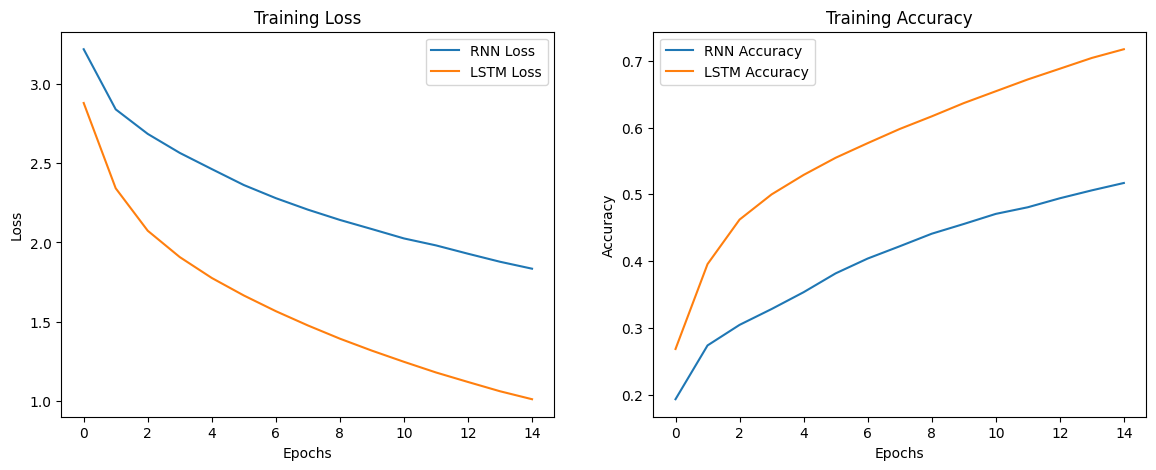

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_rnn, label="RNN Loss")
plt.plot(train_losses_lstm, label="LSTM Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs_rnn, label="RNN Accuracy")
plt.plot(train_accs_lstm, label="LSTM Accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### STEP 9: Test code of the model

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from nltk.translate.bleu_score import sentence_bleu

def evaluate(model, dataloader):
    model.eval()
    model.to(device)
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred += predicted.cpu().tolist()
            y_true += labels.cpu().tolist()
    return y_pred, y_true

def show_metrics(y_true, y_pred, title):
    print(f"\nFor {title} ")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:")
    plt.figure(figsize=(10, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=False, fmt='d', cmap='Blues')
    plt.title(f"{title} Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    bleu_scores = [sentence_bleu([[str(gt)]], [str(pred)], weights=(1.0,)) for gt, pred in zip(y_true, y_pred)]
    print("Avg BLEU Score:", np.mean(bleu_scores))
    print("\nSample Predictions:")
    for i in range(5):
        print(f"Pred: {le.inverse_transform([y_pred[i]])[0]} | True: {le.inverse_transform([y_true[i]])[0]} | Headline: {df['headline'].iloc[i]}")



### STEP 10: Testing the model

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



For RNN Test Evaluation 
Accuracy: 0.42459313702095164
Confusion Matrix:


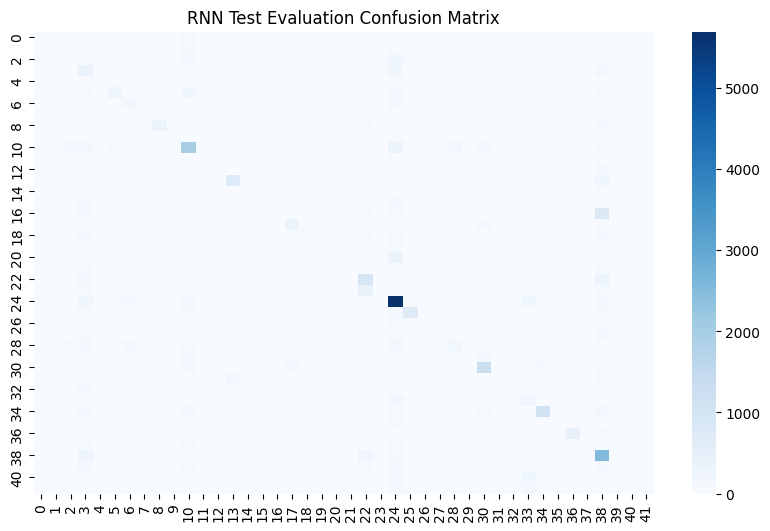

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

          ARTS       0.10      0.01      0.01       314
ARTS & CULTURE       0.00      0.00      0.00       285
  BLACK VOICES       0.15      0.09      0.11       928
      BUSINESS       0.11      0.33      0.17      1186
       COLLEGE       0.00      0.00      0.00       221
        COMEDY       0.53      0.25      0.34      1058
         CRIME       0.15      0.28      0.19       714
CULTURE & ARTS       0.00      0.00      0.00       225
       DIVORCE       0.71      0.51      0.59       694
     EDUCATION       0.11      0.00      0.01       216
 ENTERTAINMENT       0.48      0.56      0.52      3532
   ENVIRONMENT       0.00      0.00      0.00       318
         FIFTY       0.00      0.00      0.00       271
  FOOD & DRINK       0.50      0.60      0.54      1247
     GOOD NEWS       0.10      0.02      0.04       275
         GREEN       0.00      0.00      0.00       559
HEALTHY LIVING       0.00      0.00      0.00  

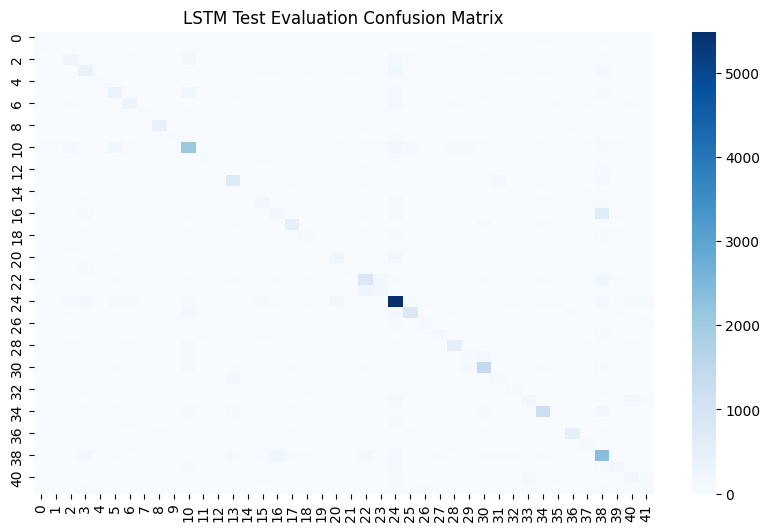

                precision    recall  f1-score   support

          ARTS       0.14      0.12      0.13       314
ARTS & CULTURE       0.11      0.06      0.08       285
  BLACK VOICES       0.30      0.29      0.29       928
      BUSINESS       0.31      0.32      0.31      1186
       COLLEGE       0.19      0.18      0.18       221
        COMEDY       0.34      0.35      0.34      1058
         CRIME       0.39      0.39      0.39       714
CULTURE & ARTS       0.40      0.25      0.31       225
       DIVORCE       0.74      0.61      0.67       694
     EDUCATION       0.28      0.16      0.20       216
 ENTERTAINMENT       0.56      0.60      0.58      3532
   ENVIRONMENT       0.32      0.16      0.21       318
         FIFTY       0.13      0.03      0.05       271
  FOOD & DRINK       0.54      0.62      0.58      1247
     GOOD NEWS       0.15      0.07      0.10       275
         GREEN       0.22      0.29      0.25       559
HEALTHY LIVING       0.24      0.12      0.16  

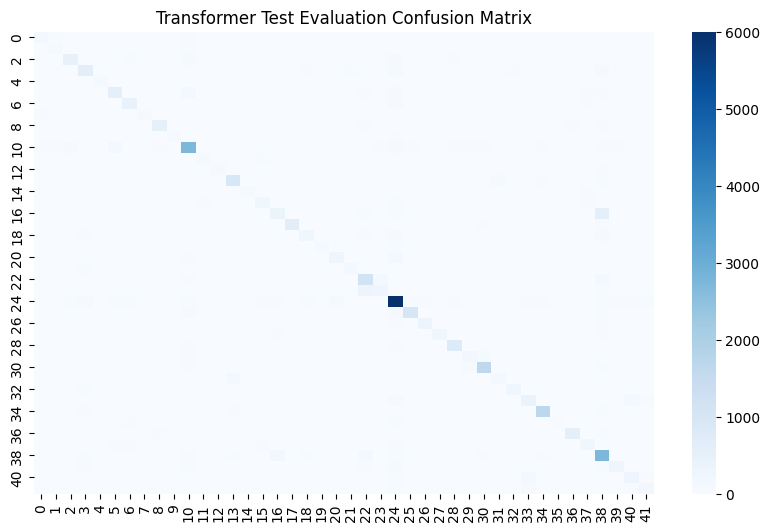

                precision    recall  f1-score   support

          ARTS       0.41      0.40      0.40       314
ARTS & CULTURE       0.46      0.37      0.41       285
  BLACK VOICES       0.59      0.48      0.53       928
      BUSINESS       0.53      0.53      0.53      1186
       COLLEGE       0.49      0.52      0.51       221
        COMEDY       0.55      0.51      0.53      1058
         CRIME       0.60      0.61      0.61       714
CULTURE & ARTS       0.65      0.33      0.44       225
       DIVORCE       0.76      0.75      0.75       694
     EDUCATION       0.51      0.40      0.45       216
 ENTERTAINMENT       0.73      0.77      0.75      3532
   ENVIRONMENT       0.62      0.37      0.46       318
         FIFTY       0.51      0.34      0.41       271
  FOOD & DRINK       0.73      0.75      0.74      1247
     GOOD NEWS       0.43      0.34      0.38       275
         GREEN       0.46      0.46      0.46       559
HEALTHY LIVING       0.42      0.29      0.35  

In [ ]:
y_pred_rnn, y_true_rnn = evaluate(rnn_model, test_loader)
y_pred_lstm, y_true_lstm = evaluate(lstm_model, test_loader)

raw_pred = trainer.predict(test_dataset)
y_pred_transformer = np.argmax(raw_pred.predictions, axis=1)
y_true_transformer = raw_pred.label_ids

show_metrics(y_true_rnn, y_pred_rnn, "RNN Test Evaluation")
show_metrics(y_true_lstm, y_pred_lstm, "LSTM Test Evaluation")
show_metrics(y_true_transformer, y_pred_transformer, "Transformer Test Evaluation")

submissions_df = pd.DataFrame({
    'headline': [" ".join(df['tokens'].iloc[i]) for i in id_test],
    'true_category': [le.inverse_transform([y])[0] for y in y_true_rnn],
    'rnn_predicted': [le.inverse_transform([y])[0] for y in y_pred_rnn],
    'lstm_predicted': [le.inverse_transform([y])[0] for y in y_pred_lstm],
    'transformer_predicted': [le.inverse_transform([y])[0] for y in y_pred_transformer],
})

submissions_df.to_csv("submissions.csv", index=False)